In [1]:
import os, json
from typing import Any, Dict

# Export labels.txt and preprocessor.json for inference
# Run this AFTER training so variables like classes/encoders and vocab/stoi are defined.

def _project_root_from_notebook() -> str:
    # Assuming this notebook lives under <root>/Movies/
    return os.path.dirname(os.getcwd())

DOMAIN = "movies"  # change per notebook
bundle_dir = os.path.join(_project_root_from_notebook(), "artifacts", DOMAIN)
os.makedirs(bundle_dir, exist_ok=True)

# 1) Write labels.txt
labels = None
if 'mlb' in globals() and hasattr(mlb, 'classes_'):
    labels = list(mlb.classes_)
elif 'le' in globals() and hasattr(le, 'classes_'):
    labels = list(le.classes_)
elif 'classes' in globals():
    labels = list(classes)

if not labels or len(labels) < 2:
    raise RuntimeError("Could not determine labels. Ensure you have 'mlb'/'le'.classes_ or a 'classes' list.")

labels_path = os.path.join(bundle_dir, "labels.txt")
with open(labels_path, "w", encoding="utf-8") as f:
    for lab in labels:
        f.write(f"{lab}\n")
print(f"Wrote labels to {labels_path} ({len(labels)} labels)")

# 2) Write preprocessor.json
word_index: Dict[str, int] = {}
if 'stoi' in globals() and isinstance(stoi, dict):
    word_index = {str(k): int(v) for k, v in stoi.items()}
elif 'word_index' in globals() and isinstance(word_index, dict):
    word_index = word_index
elif 'vocab' in globals() and isinstance(vocab, list):
    word_index = {str(w): int(i) for i, w in enumerate(vocab)}
else:
    raise RuntimeError("Could not determine word_index. Provide 'stoi', 'word_index', or 'vocab' list.")

max_length = 256
for key in ("MAX_SEQ_LEN", "MAX_LEN", "SEQ_LEN", "MAX_LENGTH"):
    if key in globals():
        try:
            max_length = int(globals()[key])
            break
        except Exception:
            pass

lowercase = True
if 'LOWERCASE' in globals():
    try:
        lowercase = bool(LOWERCASE)
    except Exception:
        pass

padding_idx = 0
if '<PAD>' in word_index:
    padding_idx = int(word_index['<PAD>'])

oov_token_id = 1
if '<UNK>' in word_index:
    oov_token_id = int(word_index['<UNK>'])

preproc = {
    "word_index": word_index,
    "max_length": int(max_length),
    "lowercase": bool(lowercase),
    "oov_token_id": int(oov_token_id),
    "padding_idx": int(padding_idx),
    "tokenizer": "regex_basic"
}

preproc_path = os.path.join(bundle_dir, "preprocessor.json")
with open(preproc_path, "w", encoding="utf-8") as f:
    json.dump(preproc, f, ensure_ascii=False)
print(f"Wrote preprocessor to {preproc_path} (|word_index|={len(word_index)})")



RuntimeError: Could not determine labels. Ensure you have 'mlb'/'le'.classes_ or a 'classes' list.

In [ ]:
# NOTE: You don't have to run this cell.
# If you have the wiki_movie_plots_deduped.csv file downloaded locally, this cell is safe to delete.
# This is only for the Google Colab setup.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
CSV_PATH = "./drive/MyDrive/dl/datasets/wiki_movie_plots_deduped.csv" # Do replace with your own path

In [ ]:
df = pd.read_csv(CSV_PATH)
df = df[df.Genre != "unknown"]

In [ ]:
df

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
6,1903,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
10,1906,Dream of a Rarebit Fiend,American,Wallace McCutcheon and Edwin S. Porter,NaN,short,https://en.wikipedia.org/wiki/Dream_of_a_Rareb...,The Rarebit Fiend gorges on Welsh rarebit at a...
11,1906,From Leadville to Aspen: A Hold-Up in the Rockies,American,Francis J. Marion and Wallace McCutcheon,NaN,short action/crime western,https://en.wikipedia.org/wiki/From_Leadville_t...,The film features a train traveling through th...
12,1906,Kathleen Mavourneen,American,Edwin S. Porter,NaN,short film,https://en.wikipedia.org/wiki/Kathleen_Mavourn...,Irish villager Kathleen is a tenant of Captain...
...,...,...,...,...,...,...,...,...
34877,2013,Particle (film),Turkish,Erdem Tepegöz,"Jale Arıkan, Rüçhan Caliskur, Özay Fecht, Remz...",drama film,https://en.wikipedia.org/wiki/Particle_(film),"Zeynep lost her job at weaving factory, and he..."
34882,2017,Çalgı Çengi İkimiz,Turkish,Selçuk Aydemir,"Ahmet Kural, Murat Cemcir",comedy,https://en.wikipedia.org/wiki/%C3%87alg%C4%B1_...,"Two musicians, Salih and Gürkan, described the..."
34883,2017,Olanlar Oldu,Turkish,Hakan Algül,"Ata Demirer, Tuvana Türkay, Ülkü Duru",comedy,https://en.wikipedia.org/wiki/Olanlar_Oldu,"Zafer, a sailor living with his mother Döndü i..."
34884,2017,Non-Transferable,Turkish,Brendan Bradley,"YouTubers Shanna Malcolm, Shira Lazar, Sara Fl...",romantic comedy,https://en.wikipedia.org/wiki/Non-Transferable...,The film centres around a young woman named Am...


## Preprocessing Movie Plot Inputs

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_most_common_words(input_text) -> None:
  """ plots 20 of the most common words from `input_text`
  """

  tokens = " ".join(input_text).lower().split()
  word_counts = Counter(tokens)

  common_words = word_counts.most_common(20)
  words, counts = zip(*common_words)

  plt.bar(words, counts)
  plt.xticks(rotation=45)
  plt.title("20 Most Common Words")
  plt.show()

In [ ]:
import numpy as np

def plot_vocab_coverage(input_text, coverage_threshold) -> None:
  """ plots the cumulative coverage of the vocabulary
  """

  tokens = " ".join(input_text).lower().split()
  word_counts = Counter(tokens)

  counts = np.array(sorted(word_counts.values(), reverse=True))
  total = counts.sum()
  cumulative_coverage = np.cumsum(counts) / total

  # Plot coverage
  plt.plot(cumulative_coverage)
  plt.xlabel("Vocabulary size")
  plt.ylabel("Cumulative coverage")
  plt.title("Vocab Coverage Curve")
  plt.grid(True)
  plt.show()

  vocab_size = np.argmax(cumulative_coverage >= coverage_threshold) + 1
  print(f"95% coverage achieved with vocab size: {vocab_size}")

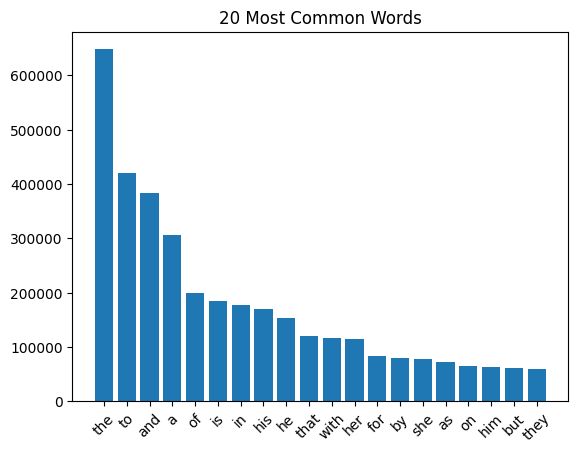

In [ ]:
plot_most_common_words(df['Plot'].to_list())

The preprocessing pipeline is condensed into the `preprocess_text` function. In chronological order, the steps we took to preprocess the movie plots are:  
* standardize all texts to lower case
* remove possibly existing html tags (i.e. '<>')
* remove punctuation but keep apostrophe
* remove stopwords but keep negation words like 'not', 'no' or 'nor' that might add to meaning
* lemmatization
* standardise spaces between the texts

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower().strip()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"[^\w\s']", '', text)

    tokens = text.split()

    # remove stopwords but keep negations like 'not', 'no', 'nor'
    filtered_tokens = [w for w in tokens if w not in stop_words or w in ['not', 'no', 'nor']]

    lemmatized = [lemmatizer.lemmatize(w) for w in filtered_tokens]

    return ' '.join(lemmatized)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
preprocessed_texts = [preprocess_text(p) for p in df['Plot'].to_list()]

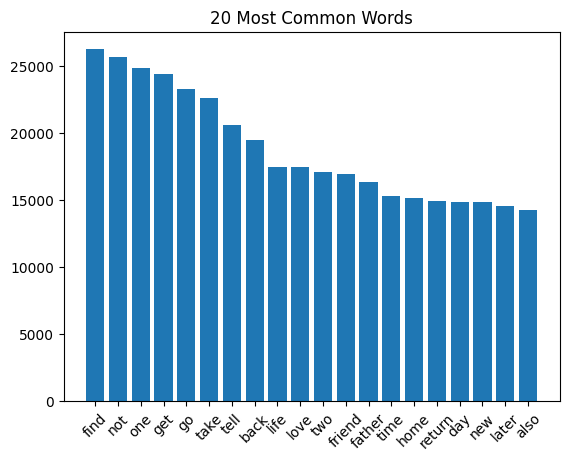

In [ ]:
plot_most_common_words(preprocessed_texts)

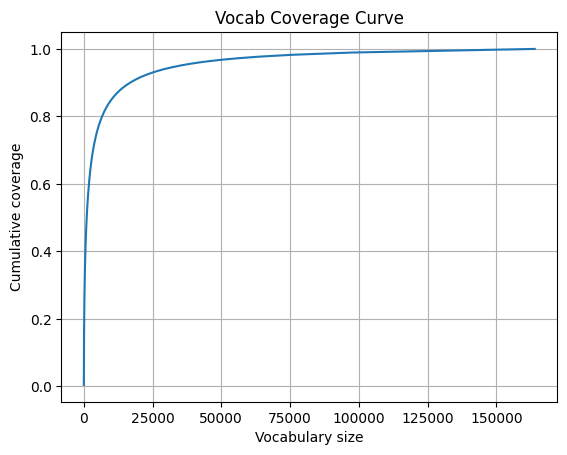

95% coverage achieved with vocab size: 34644


In [ ]:
ideal_vocab_coverage = 0.95
plot_vocab_coverage(preprocessed_texts, ideal_vocab_coverage)

We build our own tokenizer with a maximum vocab size of 34648 (34644 + 4) consisting of:
* 34644 words from the 95% vocabulary coverage as shown in the cell above
* 4 special tokens `<PAD>`, `<UNK>`, `<SOS>`, `<EOS>`, which are padding tokens, unknown words (out of vocabulary tokens), start of sentence, and end of sentence respectively.

In [ ]:
BATCH_SIZE = 32
RANDOM_SEED = 42
VOCAB_SIZE = 34648
TEST_SPLIT = 0.15
VAL_SPLIT = 0.2 # note that this split is not absolute, it is relative to the training data that is already split by TEST_SPLIT

In [ ]:
words = [w for t in preprocessed_texts for w in t.split()]

freqs = Counter(words)
vocab = ['<PAD>', '<UNK>', '<SOS>', '<EOS>'] + [w for w, _ in freqs.most_common(VOCAB_SIZE - 4)]
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}

def encode(t):
    tokens = t.split()
    return [stoi.get('<SOS>')] + [stoi.get(w, stoi['<UNK>']) for w in tokens] + [stoi.get('<EOS>')]

## Preprocessing Movie Genres to Classify

In this step, we decide what the labels in the classification problem will be and how they are represented for the model to learn from.

In [ ]:
print(df["Genre"].value_counts())

Genre
drama                                                              5964
comedy                                                             4379
horror                                                             1167
action                                                             1098
thriller                                                            966
                                                                   ... 
drama, sports (road bicycle racing), comedy-drama                     1
fantasy, sci-fi, action, mecha, supernatural                          1
drama, slice of life, sports (aquatics, swimming), comedy-drama       1
drama, children's, comedy-drama, youth, romance, slice of life        1
drama, romance, youth, mystery                                        1
Name: count, Length: 2264, dtype: int64


In [ ]:
def split_genres(text):
  """ splits the genres into a list of strings
  """
  if not isinstance(text, str):
      return []
  parts = re.split(r'[,/|\s]+', text.lower())
  parts = [p.strip() for p in parts if p.strip()]
  return list(dict.fromkeys(parts))

In [ ]:
def plot_genre_freq_distribution(genre_counts):
  """ similar to plotting the most common words, but for genres. This time only the top 10 genres.
  """
  common_words = genre_counts.most_common(10)
  genre, counts = zip(*common_words)

  plt.bar(genre, counts)
  plt.xticks(rotation=45)
  plt.title("Top 10 Genre Frequency Distribution")
  plt.show()

In [ ]:
genre_list = []

for genre_str in df["Genre"]:
  genre_list.append(split_genres(genre_str))

The below cell shows what the labels will look like.

This is a multi-label classification problem ***(not to be confused with multi-class)***. Meaning that each movie can be classified into more than one genre. As shown below, a single movie can be 'short', 'action', 'crime', and 'western' all at once.

In [ ]:
genre_list[:10]

[['western'],
 ['comedy'],
 ['short'],
 ['short', 'action', 'crime', 'western'],
 ['short', 'film'],
 ['biographical'],
 ['comedy'],
 ['comedy'],
 ['drama'],
 ['drama']]

Since the less popular genres will blow the total class number up making the classification problem very sparse, we collect the top 10 most common genres from the plot.

In [ ]:
from collections import Counter

all_genres = [g for sublist in genre_list for g in sublist]
genre_counts = Counter(all_genres)

top_genres = [g for g, _ in genre_counts.most_common(10)]
print(top_genres)

['drama', 'comedy', 'action', 'romance', 'thriller', 'crime', 'horror', 'western', 'musical', 'adventure']


If a movie only classifies in genres that are not in the top 10, we label its genre as 'other'.

In [ ]:
genre_list = [[g for g in sublist if g in top_genres] for sublist in genre_list]

for i in range(len(genre_list)):
  if len(genre_list[i]) == 0:
    genre_list[i] = ["other"]

**NOTE: The label frequency distribution is imbalanced. Something has to be done during training (e.g. using weight class during training)**

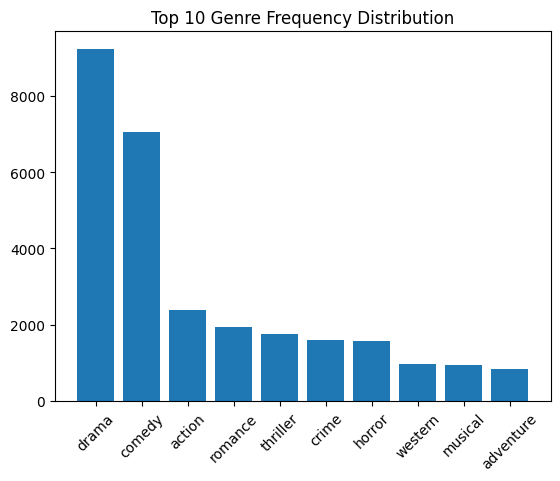

In [ ]:
plot_genre_freq_distribution(genre_counts)

We encode the classes into a vector of length 11. Each index in the vector represents a genre of the movie to classify.

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(genre_list)

print("All possible genres:", mlb.classes_)

All possible genres: ['action' 'adventure' 'comedy' 'crime' 'drama' 'horror' 'musical' 'other'
 'romance' 'thriller' 'western']


An example of a label's vector representation can be seen below.

In [ ]:
print("Sample label: ", genre_list[3])
print("The corresponding vector representation: ", y[3])

Sample label:  ['action', 'crime', 'western']
The corresponding vector representation:  [1 0 0 1 0 0 0 0 0 0 1]


## Preparing the DataLoader

In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class MovieDataset(Dataset):
    def __init__(self, plots, labels):
        self.data = [torch.tensor(encode(p), dtype=torch.long) for p in plots]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def collate_fn(batch):
    data, labels = zip(*batch)
    padded = pad_sequence(data, batch_first=True, padding_value=0)
    return padded, torch.stack(labels)

With the current train, val, test data split, the distribution of data samples will look consist of 15% test, 17% validation, 68% training data.

This is given that `TEST_SPLIT = 0.15` and `VAL_SPLIT = 0.2`.

In [ ]:
from sklearn.model_selection import train_test_split

train_plots, test_plots, y_train, y_test = train_test_split(preprocessed_texts, y, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
 # split training set again into train/val
train_plots, val_plots, y_train, y_val = train_test_split(train_plots, y_train, test_size=VAL_SPLIT, random_state=RANDOM_SEED)

train_ds = MovieDataset(train_plots, y_train)
val_ds = MovieDataset(val_plots, y_val)
test_ds = MovieDataset(test_plots, y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## Inspecting the DataLoader

In [ ]:
data_iter = iter(train_dl)
batch = next(data_iter)

inputs, labels = batch
print(inputs.shape)
print(labels.shape)

torch.Size([32, 1121])
torch.Size([32, 11])


Each training batch has 32 samples (due to `BATCH_SIZE = 32`).

Each training input is of size 548 in this specific sample due to padding. Note that different batches may have different input lengths.

There are consistently 11 labels throughout training, i.e. the top 10 genres + `other`.

## Setting Class Weights for Imbalanced Dataset

In [ ]:
# Calculate the number of positive samples for each class in the training set
positive_counts = y_train.sum(axis=0)
total_samples = len(y_train)

# Calculate weights for the BCEWithLogitsLoss pos_weight argument
# Weight = Number of negative samples / Number of positive samples
class_weights = (total_samples - positive_counts) / positive_counts

# Convert to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = class_weights_tensor.to(device)

print("Class Weights:", class_weights_tensor)

Class Weights: tensor([11.0227, 33.1202,  3.0947, 16.9022,  2.1291, 16.8858, 29.8425,  4.7468,
        13.5722, 15.2937, 29.0383], device='cuda:0')


In [ ]:
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bidirectional = bidirectional
        self.rnn = nn.RNN(
            embed_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        # Concatenate final forward and backward hidden states
        if self.bidirectional:
            hidden = hidden[-2:, :, :]  # last two layers (forward & backward)
            hidden = hidden.transpose(0, 1).reshape(hidden.size(1), -1)  # concat fwd+bwd
        else:
            hidden = hidden[-1, :, :]
        return self.fc(hidden)


class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout, bidirectional=True):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        if self.bidirectional:
            hidden = hidden[-2:, :, :]  # last two layers (fwd & bwd)
            hidden = hidden.transpose(0, 1).reshape(hidden.size(1), -1)
        else:
            hidden = hidden[-1, :, :]
        return self.fc(hidden)


class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout, bidirectional=True):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bidirectional = bidirectional
        self.gru = nn.GRU(
            embed_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        if self.bidirectional:
            hidden = hidden[-2:, :, :]
            hidden = hidden.transpose(0, 1).reshape(hidden.size(1), -1)
        else:
            hidden = hidden[-1, :, :]
        return self.fc(hidden)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time
from tqdm import tqdm

# -----------------------------
# Training / Validation
# -----------------------------
print(f"Using device: {device}")

def train_model(model, train_dl, val_dl, epochs, lr, checkpoint_path, patience, weight_decay):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for X, y in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dl)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X, y in val_dl:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += criterion(y_pred, y).item()
                all_preds.append((torch.sigmoid(y_pred) > 0.5).int().cpu())
                all_labels.append(y.cpu().int())
        val_loss /= len(val_dl)
        all_preds = torch.vstack(all_preds).numpy()
        all_labels = torch.vstack(all_labels).numpy()
        val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

        # # Scheduler step
        # scheduler.step(val_f1)

        # Early stopping & checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            counter = 0
            print(f"Saved best model at epoch {epoch+1} with Val F1: {val_f1:.4f}")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

# -----------------------------
# Evaluation
# -----------------------------
def evaluate(model, test_dl, model_name):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for X, y in test_dl:
            X = X.to(device)
            y_pred = model(X)

            preds.append((torch.sigmoid(y_pred) > 0.5).int().cpu())
            labels.append(y.int())

    preds = torch.vstack(preds).numpy()
    labels = torch.vstack(labels).numpy()

    print(f"\n=== Evaluating {model_name} on Test Set ===")
    print("Accuracy:", accuracy_score(labels, preds))
    print("Precision (weighted):", precision_score(labels, preds, average='weighted', zero_division=0))
    print("Recall (weighted):", recall_score(labels, preds, average='weighted', zero_division=0))
    print("F1-Score (weighted):", f1_score(labels, preds, average='weighted', zero_division=0))
    print("\n")
    print(classification_report(labels, preds, target_names=mlb.classes_, zero_division=0))

Using device: cuda


In [ ]:
# --- Hyperparameters ---
VOCAB_SIZE_MODEL = len(vocab)
EMBED_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = len(mlb.classes_)
NUM_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001  # <<< REDUCED LEARNING RATE
EPOCHS = 20
PATIENCE = 4
WEIGHT_DECAY = 0

In [ ]:
print(f"\n=== Training RNN ===")
model = RNNClassifier(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
train_model(model, train_dl, val_dl, epochs=EPOCHS, lr=LEARNING_RATE, checkpoint_path=f'best_RNN.pt', patience=PATIENCE, weight_decay=WEIGHT_DECAY)


print(f"=== Evaluating RNN on Test Set ===")
model.load_state_dict(torch.load(f'best_RNN.pt'))
evaluate(model, test_dl, 'RNN')


=== Training RNN ===


Epoch 1/20 | Train Loss: 1.2928 | Val Loss: 1.2974 | Val F1: 0.1406
Saved best model at epoch 1 with Val F1: 0.1406


Epoch 2/20 | Train Loss: 1.2864 | Val Loss: 1.2681 | Val F1: 0.2946
Saved best model at epoch 2 with Val F1: 0.2946


Epoch 3/20 | Train Loss: 1.2720 | Val Loss: 1.3414 | Val F1: 0.2279


Epoch 4/20 | Train Loss: 1.2704 | Val Loss: 1.2522 | Val F1: 0.1783
Saved best model at epoch 4 with Val F1: 0.1783


Epoch 5/20 | Train Loss: 1.2694 | Val Loss: 1.2651 | Val F1: 0.1778


Epoch 6/20 | Train Loss: 1.2599 | Val Loss: 1.2569 | Val F1: 0.2652


Epoch 7/20 | Train Loss: 1.2540 | Val Loss: 1.2386 | Val F1: 0.2210
Saved best model at epoch 7 with Val F1: 0.2210


Epoch 8/20 | Train Loss: 1.2362 | Val Loss: 1.2239 | Val F1: 0.2879
Saved best model at epoch 8 with Val F1: 0.2879


Epoch 9/20 | Train Loss: 1.2169 | Val Loss: 1.2833 | Val F1: 0.2526


Epoch 10/20 | Train Loss: 1.1904 | Val Loss: 1.2772 | Val F1: 0.2844


Epoch 11/20 | Train Loss: 1.1728 | Val Loss: 1.2180 | Val F1: 0.2393
Saved best model at epoch 11 with Val F1: 0.2393


Epoch 12/20 | Train Loss: 1.1705 | Val Loss: 1.2204 | Val F1: 0.2855


Epoch 13/20 | Train Loss: 1.1481 | Val Loss: 1.2530 | Val F1: 0.2679


Epoch 14/20 | Train Loss: 1.1401 | Val Loss: 1.2767 | Val F1: 0.2876


Epoch 15/20 | Train Loss: 1.1301 | Val Loss: 1.2240 | Val F1: 0.2908
Early stopping triggered.
=== Evaluating RNN on Test Set ===

=== Evaluating RNN on Test Set ===
Accuracy: 0.003934274473501504
Precision (weighted): 0.22949061759078446
Recall (weighted): 0.45527156549520764
F1-Score (weighted): 0.24052542559645185


              precision    recall  f1-score   support

      action       0.10      0.42      0.16       367
   adventure       0.05      0.50      0.09       130
      comedy       0.27      0.70      0.39      1077
       crime       0.08      0.47      0.13       233
       drama       0.39      0.15      0.21      1407
      horror       0.08      0.36      0.12       229
     musical       0.04      0.37      0.07       145
       other       0.18      0.63      0.28       712
     romance       0.09      0.80      0.17       294
    thriller       0.07      0.30      0.11       256
     western       0.31      0.61      0.41       158

   micro avg       0.14      

In [ ]:
print(f"\n=== Training LSTM ===")
model = LSTMClassifier(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
train_model(model, train_dl, val_dl, epochs=EPOCHS, lr=LEARNING_RATE, checkpoint_path=f'best_LSTM.pt', patience=PATIENCE, weight_decay=WEIGHT_DECAY)

print(f"=== Evaluating LSTM on Test Set ===")
model.load_state_dict(torch.load(f'best_LSTM.pt'))
evaluate(model, test_dl, 'LSTM')


=== Training LSTM ===


Epoch 1/20 | Train Loss: 1.2230 | Val Loss: 1.1787 | Val F1: 0.2932
Saved best model at epoch 1 with Val F1: 0.2932


Epoch 2/20 | Train Loss: 1.1696 | Val Loss: 1.3047 | Val F1: 0.2916


Epoch 3/20 | Train Loss: 1.0859 | Val Loss: 1.0217 | Val F1: 0.3592
Saved best model at epoch 3 with Val F1: 0.3592


Epoch 4/20 | Train Loss: 0.9849 | Val Loss: 0.9570 | Val F1: 0.3832
Saved best model at epoch 4 with Val F1: 0.3832


Epoch 5/20 | Train Loss: 0.9116 | Val Loss: 0.9424 | Val F1: 0.3957
Saved best model at epoch 5 with Val F1: 0.3957


Epoch 6/20 | Train Loss: 0.8450 | Val Loss: 0.9336 | Val F1: 0.4185
Saved best model at epoch 6 with Val F1: 0.4185


Epoch 7/20 | Train Loss: 0.7959 | Val Loss: 0.9260 | Val F1: 0.4207
Saved best model at epoch 7 with Val F1: 0.4207


Epoch 8/20 | Train Loss: 0.7543 | Val Loss: 0.9498 | Val F1: 0.4227


Epoch 9/20 | Train Loss: 0.7187 | Val Loss: 0.9688 | Val F1: 0.4344


Epoch 10/20 | Train Loss: 0.6732 | Val Loss: 1.0174 | Val F1: 0.4294


Epoch 11/20 | Train Loss: 0.6456 | Val Loss: 1.0506 | Val F1: 0.4371
Early stopping triggered.
=== Evaluating LSTM on Test Set ===

=== Evaluating LSTM on Test Set ===
Accuracy: 0.032168479518629944
Precision (weighted): 0.32004379138482403
Recall (weighted): 0.7116613418530351
F1-Score (weighted): 0.4279592436026376


              precision    recall  f1-score   support

      action       0.22      0.74      0.33       367
   adventure       0.13      0.45      0.21       130
      comedy       0.40      0.60      0.48      1077
       crime       0.17      0.79      0.28       233
       drama       0.39      0.82      0.53      1407
      horror       0.32      0.79      0.45       229
     musical       0.12      0.54      0.20       145
       other       0.31      0.55      0.39       712
     romance       0.15      0.84      0.26       294
    thriller       0.13      0.78      0.23       256
     western       0.59      0.92      0.72       158

   micro avg       0.27      

In [ ]:
print(f"\n=== Training GRU ===")
model = GRUClassifier(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
train_model(model, train_dl, val_dl, epochs=EPOCHS, lr=LEARNING_RATE, checkpoint_path=f'best_GRU.pt', patience=PATIENCE, weight_decay=WEIGHT_DECAY)

print(f"=== Evaluating GRU on Test Set ===")
model.load_state_dict(torch.load(f'best_GRU.pt'))
evaluate(model, test_dl, 'GRU')


=== Training GRU ===


Epoch 1/20 | Train Loss: 1.2321 | Val Loss: 1.1709 | Val F1: 0.3112
Saved best model at epoch 1 with Val F1: 0.3112


Epoch 2/20 | Train Loss: 1.1319 | Val Loss: 1.0789 | Val F1: 0.3573
Saved best model at epoch 2 with Val F1: 0.3573


Epoch 3/20 | Train Loss: 0.9781 | Val Loss: 0.9747 | Val F1: 0.3870
Saved best model at epoch 3 with Val F1: 0.3870


Epoch 4/20 | Train Loss: 0.8579 | Val Loss: 0.8729 | Val F1: 0.4214
Saved best model at epoch 4 with Val F1: 0.4214


Epoch 5/20 | Train Loss: 0.7812 | Val Loss: 0.8752 | Val F1: 0.4316


Epoch 6/20 | Train Loss: 0.7123 | Val Loss: 0.8881 | Val F1: 0.4527


Epoch 7/20 | Train Loss: 0.6631 | Val Loss: 0.9767 | Val F1: 0.4530


Epoch 8/20 | Train Loss: 0.6208 | Val Loss: 1.0444 | Val F1: 0.4505
Early stopping triggered.
=== Evaluating GRU on Test Set ===

=== Evaluating GRU on Test Set ===
Accuracy: 0.03077991205739412
Precision (weighted): 0.3238688573844529
Recall (weighted): 0.7024760383386581
F1-Score (weighted): 0.426600310396456


              precision    recall  f1-score   support

      action       0.28      0.67      0.40       367
   adventure       0.11      0.73      0.19       130
      comedy       0.40      0.66      0.50      1077
       crime       0.19      0.79      0.31       233
       drama       0.44      0.68      0.53      1407
      horror       0.19      0.92      0.32       229
     musical       0.10      0.75      0.18       145
       other       0.31      0.61      0.41       712
     romance       0.18      0.75      0.29       294
    thriller       0.13      0.75      0.22       256
     western       0.34      0.97      0.50       158

   micro avg       0.26      0.70  